In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [27]:
# import data 
dataset = pd.read_csv('../input/all_data.csv')

# remove any output files previously created when checking for invalid data
for column in dataset.columns.values:
    filepath = 'output/invalid_' + column + '.txt'
    if os.path.exists(filepath):
        os.remove(filepath)

In [28]:
def output_invalid_number(col, ind, val):
    """Output the index and value of an invalid value to a .txt file
    
    col -- the column the value exists in
    ind -- the index the value is at in the dataset
    val -- the value
    """
    f = open('output/invalid_' + col + '.txt', 'a+')
    f.write(str(ind) + ',' + str(val) + '\n')
    return np.NaN

In [29]:
def output_invalid_condition(ind, val):
    """Output the index and value of an invalid condition to a .txt file
    
    ind -- the index the value is at in the dataset
    val -- the value
    """
    f = open('output/invalid_condition.txt', 'a+')
    f.write(str(ind) + ',' + str(val) + '\n')
    return None

In [30]:
dataset.describe()

tem          hum          dis          vib          aud
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000
mean     25.488295    55.008350     8.969687     0.038500    56.058750
std       1.733390     3.535056     7.540033     0.192424    17.533547
min      19.190000    44.310000     1.290000     0.000000    10.000000
25%      24.337500    52.440000     1.660000     0.000000    41.000000
50%      25.590000    55.075000     1.900000     0.000000    48.000000
75%      26.690000    57.660000    16.600000     0.000000    71.750000
max      30.360000    65.210000    20.200000     1.000000    84.000000

In [31]:
dataset[:10]

tem    hum    dis  vib    aud                               condition
0  23.49  49.19  15.40    0  78.75  Internal Electrical Insulation Failure
1  24.05  47.81  15.00    0  71.75  Internal Electrical Insulation Failure
2  23.39  50.07  15.30    0  70.00  Internal Electrical Insulation Failure
3  25.00  48.94  17.80    0  71.75  Internal Electrical Insulation Failure
4  22.73  48.65  14.90    0  75.25  Internal Electrical Insulation Failure
5  23.16  48.73   1.58    1  73.50                      Mechanical Failure
6  24.13  53.81  16.50    0  70.00  Internal Electrical Insulation Failure
7  24.83  46.59  15.80    0  61.25  Internal Electrical Insulation Failure
8  24.10  48.72  14.70    0  82.25  Internal Electrical Insulation Failure
9  24.88  50.91  13.60    0  70.00  Internal Electrical Insulation Failure

<h3>Cleaning Data:</h3>

In [52]:
## convert non numeric values to NaN
dataset['tem'] = pd.to_numeric(dataset['tem'], errors='coerce')
dataset['hum'] = pd.to_numeric(dataset['hum'], errors='coerce')
dataset['dis'] = pd.to_numeric(dataset['dis'], errors='coerce')
dataset['vib'] = pd.to_numeric(dataset['vib'], errors='coerce')

In [53]:
## convert values to NaN if not in the specified range
# temperature between 19 and 31
dataset['tem'] = [val if (19 <= val <= 31) else output_invalid_number('tem', ind, val) for ind, val in enumerate(dataset['tem'])]

# relative humidity between 44 and 66
dataset['hum'] = [val if (44 <= val <= 66) else output_invalid_number('hum', ind, val) for ind, val in enumerate(dataset['hum'])]

# partial discharge between 1 and 20
dataset['dis'] = [val if (1 <= val <= 66) else output_invalid_number('partial_discharge', ind, val) for ind, val in enumerate(dataset['dis'])]

# vibration level 0, 1, or 5
dataset['vib'] = [val if (val == 0 or val == 1 or val == 5) else output_invalid_number('vib', ind, val) for ind, val in enumerate(dataset['vib'])]
# vibration level --> replace 5 with 1
dataset['vib'] = dataset['vib'].replace(5, 1)

# audio between 10 and 84
dataset['audio'] = [val if (10 <= val <= 84) else output_invalid_number('audio', ind, val) for ind, val in enumerate(dataset['audio'])]

KeyError: 'audio'

In [34]:
conditions = [
    'good',
    'internal electrical insulation failure',
    'mechanical failure',
    'both electrical and mechanical failure',
]

# convert to lower case for comparison to conditions list
dataset['condition'] = dataset['condition'].str.lower()
# filter the condtions to None if not in the conditions list
dataset['condition'] = [val if val in conditions else output_invalid_condition(ind, val) for ind, val in enumerate(dataset['condition'])]

<h3>Preparing Data:</h3>

In [54]:
## remove rows that had any null values to be used as features
X = dataset.dropna(axis=0, how='any').drop(columns=['condition'])

## hold conditions to be used as y
y = dataset.dropna(axis=0, how='any')['condition']

## split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
## scale training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h3>KNN Algorithm:</h3>

In [56]:
## define KNN model
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

## predict values based off model
y_pred = knn.predict(X_test)

In [57]:
## evaluate performance of model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('accuracy score: ' + str(accuracy_score(y_test, y_pred) * 100) + '%')

[[393   0   0]
 [  0 109   0]
 [  0   0   7]]
                                        precision    recall  f1-score   support

                                  good       1.00      1.00      1.00       393
internal electrical insulation failure       1.00      1.00      1.00       109
                    mechanical failure       1.00      1.00      1.00         7

                              accuracy                           1.00       509
                             macro avg       1.00      1.00      1.00       509
                          weighted avg       1.00      1.00      1.00       509

accuracy score: 100.0%


<h3>Find value for K with lowest error rate:</h3>

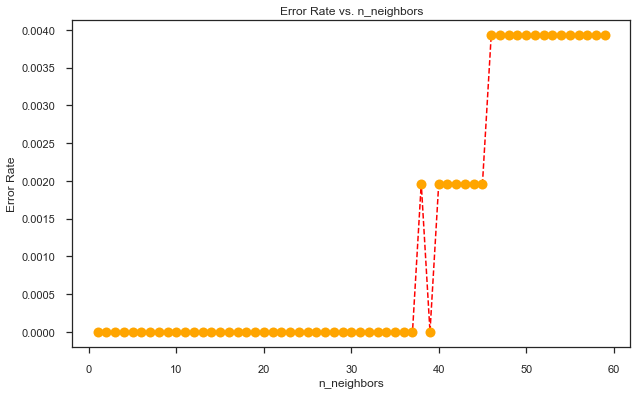

In [58]:
error_rate = []

for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

## plot graph to show best value for K
plt.figure(figsize=(10,6))
plt.plot(range(1,60), error_rate, color='red', linestyle='--', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Error Rate vs. n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Error Rate')
plt.show()

In [59]:
## use the new value for K based on the above chart
knn_2 = KNeighborsClassifier(n_neighbors=3)
knn_2.fit(X_train, y_train)

y_pred_2 = knn_2.predict(X_test)

print(confusion_matrix(y_test, y_pred_2))
print(classification_report(y_test, y_pred_2))
print('accuracy score: ' + str(accuracy_score(y_test, y_pred_2) * 100) + '%')

[[393   0   0]
 [  0 109   0]
 [  0   0   7]]
                                        precision    recall  f1-score   support

                                  good       1.00      1.00      1.00       393
internal electrical insulation failure       1.00      1.00      1.00       109
                    mechanical failure       1.00      1.00      1.00         7

                              accuracy                           1.00       509
                             macro avg       1.00      1.00      1.00       509
                          weighted avg       1.00      1.00      1.00       509

accuracy score: 100.0%


In [60]:
## save the new knn model to be reused in future
from sklearn.externals import joblib
joblib.dump(knn_2,'knn_model')

['knn_model']

<h3>Visualize the data:</h3>

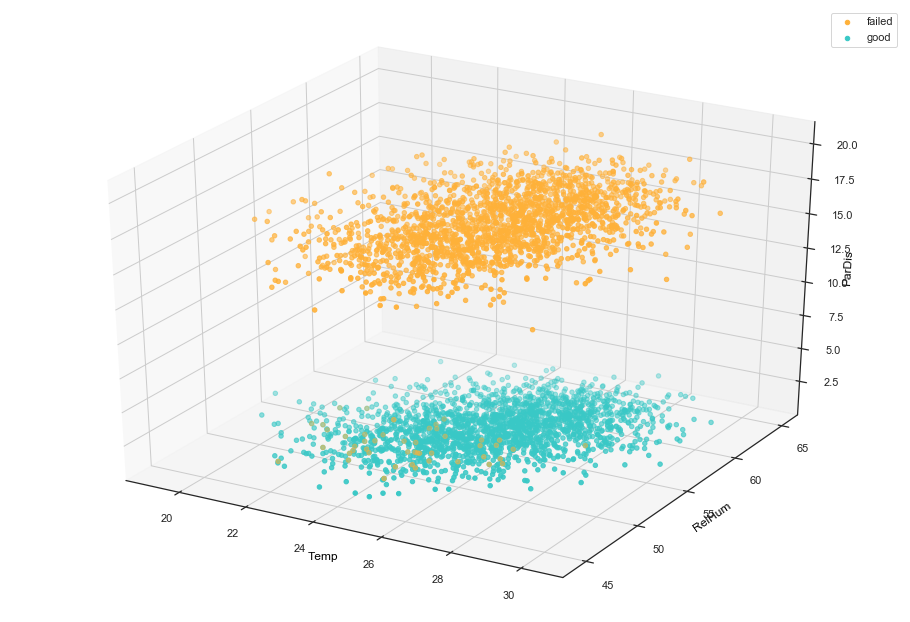

In [61]:
## Partial Discharge to Temperature and Relative Humidity
## from Nico's notebook
df = pd.read_csv('../input/SampleData.csv')

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

good = df[df['BushingCondition'] == 'good']
failed = df[df['BushingCondition'] == 'failed']

ax.scatter(failed['Temp'], failed['RelHum'], failed['ParDis'], c='#FFB139', label='failed')
ax.scatter(good['Temp'], good['RelHum'], good['ParDis'], c='#39C8C6', label='good')

ax.legend()
ax.set_xlabel('Temp', color='#000000')
ax.set_ylabel('RelHum', color='#000000')
ax.set_zlabel('ParDis', color='#000000')

plt.tight_layout()
plt.style.use('seaborn-poster')
plt.show()

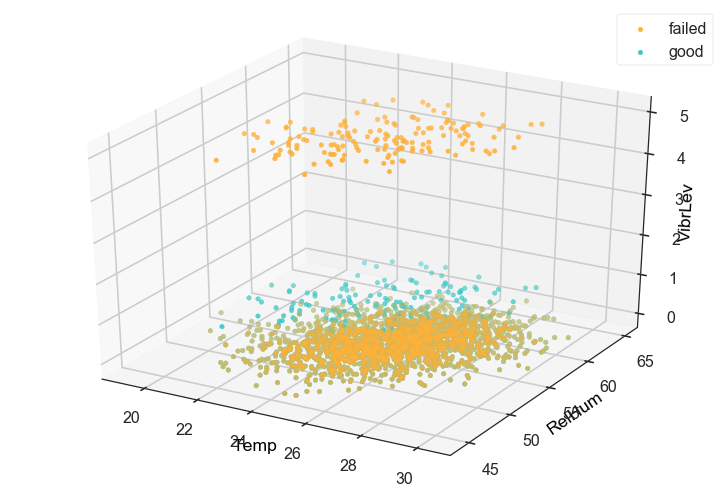

In [62]:
## Vibration to Temperature and Relative Humidity
# from Nico's notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.style.use('seaborn-poster')

good = df[df['BushingCondition'] == 'good']
failed = df[df['BushingCondition'] == 'failed']

ax.scatter(failed['Temp'], failed['RelHum'], failed['VibrLev'], c='#FFB139', label='failed')
ax.scatter(good['Temp'], good['RelHum'], good['VibrLev'], c='#39C8C6', label='good')

ax.legend()
ax.set_xlabel('Temp', color='#000000')
ax.set_ylabel('RelHum', color='#000000')
ax.set_zlabel('VibrLev', color='#000000')

plt.show()

In [63]:
## print the count of each condition
for condition in conditions:
    print(condition + ': ' + str(len(y[y == condition])))

good: 2000
internal electrical insulation failure: 491
mechanical failure: 48
both electrical and mechanical failure: 4


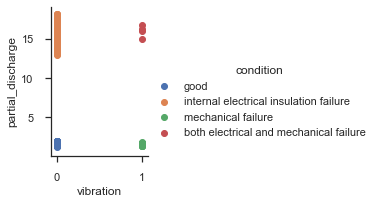

In [71]:
## compare partial discharge to vibration
import seaborn
seaborn.set(style='ticks')

pardis_vibr = pd.DataFrame({
    'vibration': X['vib'],
    'partial_discharge': X['dis'],
    'condition': y
})
fg = seaborn.FacetGrid(data=pardis_vibr, hue='condition', hue_order=conditions)
fg.map(plt.scatter, 'vibration', 'partial_discharge').add_legend()

<h3>Use model to predict labels:</h3>

In [78]:
## find rows without a label
unlabeled = dataset[dataset['condition'].isnull()]
unlabeled_X = unlabeled.drop(columns=['condition'])

In [79]:
## use second KNN algorithm to predict labels
unlabeled_pred = knn_2.predict(unlabeled_X)

In [80]:
## print the count of each condition the model predicted
for condition in conditions:
    print(condition + ': ' + str(len(unlabeled_pred[unlabeled_pred == condition])))

good: 44
internal electrical insulation failure: 1413
mechanical failure: 0
both electrical and mechanical failure: 0


<h3>Visualize the unlabeled data:</h3>

In [84]:
## plot unlabeled data without classes
pardis_vibr = pd.DataFrame({
    'vibration': unlabeled_X['vib'],
    'partial_discharge': unlabeled_X['dis'],
})
fg = seaborn.FacetGrid(data=pardis_vibr)
fg.map(plt.scatter, 'vibration', 'partial_discharge').add_legend()

In [85]:
## partial discharge values are all above ~13 which should indicate a failure, yet there are values being labeled as good

In [87]:
pardis_vibr = pd.DataFrame({
    'vibration': unlabeled_X['vib'],
    'partial_discharge': unlabeled_X['dis'],
    'condition': unlabeled_pred
})
fg = seaborn.FacetGrid(data=pardis_vibr, hue='condition', hue_order=conditions.reverse())
fg.map(plt.scatter, 'vibration', 'partial_discharge').add_legend()